<center style="font-size:30px; font-weight:bold">DATA7703, Practical 10 Solutions<center>
    <br>
<center style="font-size:20px">2021 Semester 2<center>

**Q1** **(a)** We load the dataset and construct a 70/30 train-test split as follows. 

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

diabetes = load_diabetes() 
X, y = load_diabetes(return_X_y=True)
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.3, random_state=42)

We can print the full dataset description as follows. There are 10 numeric predictive features. The target variable is a quantitative measure of diabetes progression one year after baseline. 

In [2]:
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

The means and standard deviations of the features are computed as follows. We can see that the means are all essentially 0, and standard deviations are all essentially 0.04756515.

In [3]:
X.mean(axis=0), X.std(axis=0)

(array([-3.63428493e-16,  1.30834257e-16, -8.04534920e-16,  1.28165452e-16,
        -8.83531559e-17,  1.32702421e-16, -4.57464634e-16,  3.77730150e-16,
        -3.83085422e-16, -3.41288202e-16]),
 array([0.04756515, 0.04756515, 0.04756515, 0.04756515, 0.04756515,
        0.04756515, 0.04756515, 0.04756515, 0.04756515, 0.04756515]))

The range of the target variable is from 25.0 to 346.0.

In [4]:
y.min(), y.max()

(25.0, 346.0)

**(b)** We have already done things like this many times by now. The solution code is shown below, together with the training and test MSEs.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_tr, y_tr)
print('R2 (train):', reg.score(X_tr, y_tr))
print('R2 (test):', reg.score(X_ts, y_ts))
print('MSE (train):', mean_squared_error(y_tr, reg.predict(X_tr)))
print('MSE (test):', mean_squared_error(y_ts, reg.predict(X_ts)))

R2 (train): 0.524413200822697
R2 (test): 0.4772920174157329
MSE (train): 2924.0416789072897
MSE (test): 2821.7385595843784


Note that the training and test R2 values are only around 0.5, that is, only about 50% of the variance in the target variable is explained by the OLS model. This suggests that the dataset is likely to be highly nonlinear or has high variance.

**(c)** We define a `run` function to repeatedly train and test a model on given training and test sets for a specified number of times, and return the training and test MSEs for all runs. 

In [6]:
from sklearn.linear_model import RANSACRegressor

def run(reg, X_tr, y_tr, X_ts, y_ts, n_trials=10):
    mse_tr = []
    mse_ts = []
    for i in range(n_trials):
        reg.fit(X_tr, y_tr)
        mse_tr.append(mean_squared_error(y_tr, reg.predict(X_tr)))
        mse_ts.append(mean_squared_error(y_ts, reg.predict(X_ts)))
    mse = np.array([mse_tr, mse_ts])
    return mse

We use the `run` function to evaluate the RANSAC regressor as follows.

In [7]:
np.random.seed(1) # for reproducibility

mse = run(RANSACRegressor(), X_tr, y_tr, X_ts, y_ts)
print('MSE (train): %.2f (%.2f)' % (mse[0].mean(), mse[0].std()))
print('MSE (test): %.2f (%.2f)' % (mse[1].mean(), mse[1].std()))

MSE (train): 5353.17 (1220.20)
MSE (test): 5018.15 (1584.04)


On average, the RANSAC regressor has much higher training and test MSEs as compared to OLS. However, note that the standard errors are high, suggesting that some runs have much better performance than the average performance. This is not very surprising considering that in (c), we have pointed out that the diabetes data is likely nonlinear or has high variance. In both cases, since RANSAC defaults to use just subsamples of size 10+1=11, the outlier detector, being a linear model, has a low probability of being a good one.

One simple way to deal with this problem is to increase the number of trials in RANSAC, so as to increase the probability of getting a good inlier detector, and thus getting a better final model. Indeed, if we increase the number of trials from the default of 100 to 1000, we observe a much better performance. However, the training and test MSEs are still not as competitive as OLS.

In [8]:
np.random.seed(1) # for reproducibility

mse = run(RANSACRegressor(max_trials=1000), X_tr, y_tr, X_ts, y_ts)
print('MSE (train): %.2f (%.2f)' % (mse[:, 0].mean(), mse[:, 0].std()))
print('MSE (test): %.2f (%.2f)' % (mse[:, 1].mean(), mse[:, 1].std()))

MSE (train): 3840.60 (220.76)
MSE (test): 3800.72 (52.02)


**(d)** We compute the means and standard errors using the code below.

In [9]:
means = []
stds = []
probs = np.arange(0.05, 1, 0.05)
for p in probs:
    mse = run(RANSACRegressor(min_samples=p), X_tr, y_tr, X_ts, y_ts)
    means.append(mse.mean(axis=1))
    stds.append(mse.std(axis=1))
means = np.array(means)
stds = np.array(stds)

We plot the means and standard errors using the code below.

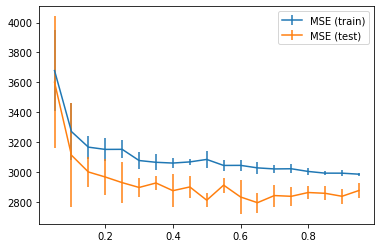

In [10]:
import matplotlib.pyplot as plt

plt.errorbar(probs, means[:, 0], yerr=stds[:, 0], label='MSE (train)')
plt.errorbar(probs, means[:, 1], yerr=stds[:, 1], label='MSE (test)')
plt.legend()
plt.show()

We can see that as we increase `min_samples`, both the training and test MSEs of RANSAC improves on average, and the variance of the performance across different runs become smaller.

**(e)** We consider support vector regressors using linear and RBF kernel, with $C$ values chosen from 0.01, 0.1, 1, 10, 100. We use 2-fold cross validation to choose a model. This can be conveniently implemented using `GridSearchCV` in `sklearn` as follows.

In [11]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1, 10, 100]}
gridcv = GridSearchCV(SVR(), parameters, cv=2)
gridcv.fit(X_tr, y_tr)
gridcv.best_estimator_

SVR(C=100)

The chosen SVR model thus uses RBF kernel, with $C=100$. The training and test MSEs of this model is shown below. We can see that it has better training set MSE and similar test set MSE as compared to OLS.

In [12]:
reg = gridcv.best_estimator_
print('MSE (train):', mean_squared_error(y_tr, reg.predict(X_tr)))
print('MSE (test):', mean_squared_error(y_ts, reg.predict(X_ts)))

MSE (train): 2019.6636018472343
MSE (test): 2819.8928454397833


**(f)** The performance plot of RANSAC using SVR in (e) as the basis model is obtained using the code below. We observe a similar effect of `min_samples` as in the case of using OLS as the basis model. However, RANSAC using SVR as the basis model has significantly better training set performance, while the test set performance is slightly worse.

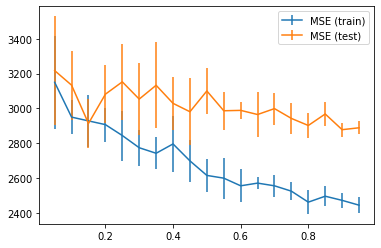

In [13]:
means = []
stds = []
probs = np.arange(0.05, 1, 0.05)
for p in probs:
    mse = run(RANSACRegressor(SVR(C=100), min_samples=p), X_tr, y_tr, X_ts, y_ts)
    means.append(mse.mean(axis=1))
    stds.append(mse.std(axis=1))
means = np.array(means)
stds = np.array(stds)

plt.errorbar(probs, means[:, 0], yerr=stds[:, 0], label='MSE (train)')
plt.errorbar(probs, means[:, 1], yerr=stds[:, 1], label='MSE (test)')
plt.legend()
plt.show()